In [1]:
""" 
In this demo we would achieve the following things

* stream data using virtualizarr (not loading directly in memory thus creating streaming in-situ processing)
* Calculate rmse of a variable across 2 datsets
* add visualizing plots

all this using data stored at s3 bucket 
"""

' \nIn this demo we would achieve the following things\n\n* stream data using virtualizarr (not loading directly in memory thus creating streaming in-situ processing)\n* Add batch processing functionality (compairing 2 datasets representing timeseries data) as in provide more flexibility while comparision\n* add visualizing plots\n\nall this using data stored at s3 bucket \n'

In [29]:
# loading dependencies
from virtualizarr import open_virtual_dataset
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

In [3]:
""" creating class data_streamer
input  - file_name : the file you want to load from s3
       - storage_options : parameters for storage options defined in above cell
       
functions -


"""
class data_streamer():
    def __init__(self,bucket_name,file_name,storage_options):
        self.bucket_name= bucket_name
        self.file_name= file_name
        self.storage_options= storage_options
        
    def virtual_referance(self):
        url =f"s3://{self.bucket_name}/{self.file_name}"
        virtual_ds = open_virtual_dataset(
        url, indexes={}, reader_options={"storage_options": storage_options})
        # Write the virtual dataset to disk as a Kerchunk JSON. We could alternative write to a Kerchunk JSON or Icechunk Store.
        virtual_ds.virtualize.to_kerchunk(f"{self.file_name}_kerchunk_reference.json", format="json")
        return f"{self.file_name}_kerchunk_reference.json"
        


In [30]:
 # adding storage options
storage_options = dict(anon=True, default_fill_cache=False, default_cache_type="none") # enables not loading anything in memory
s3_bucket_name= "ioostestbucket"  # s3 bucket where file is stored - currently hardcoded for demo can be taken as input


In [7]:
# creating referance jsons for 2 netcdf files in s3 buckets

file1 = "nos.cbofs.fields.f001.20231127.t06z.nc"
data1= data_streamer(s3_bucket_name,file1,storage_options)
json1 = data1.virtual_referance()
print(json1)


file2="nos.cbofs.fields.f001.20231127.t12z.nc"
data2 = data_streamer(s3_bucket_name,file2,storage_options)
json2= data2.virtual_referance()
print(json2)

nos.cbofs.fields.f001.20231127.t12z.nc_kerchunk_reference.json


In [31]:
#json1 = "nos.cbofs.fields.f001.20231127.t06z.nc_kerchunk_reference.json"
#json2= "nos.cbofs.fields.f001.20231127.t12z.nc_kerchunk_reference.json"

In [32]:
# streaming data using xarray from refrance jsons using kerchunk engine

ds1 = xr.open_dataset(
    f"{json1}",
    engine="kerchunk",
    backend_kwargs={"storage_options": storage_options},
)
ds2 = xr.open_dataset(
    f"{json2}",
    engine="kerchunk",
    backend_kwargs={"storage_options": storage_options},
)

In [37]:
ds1['temp']

<xarray.DataArray 'temp' (ocean_time: 1, s_rho: 20, eta_rho: 291, xi_rho: 332)> Size: 8MB
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], shape=(1, 20, 291, 332), dtype=float32)
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 773kB ...
    lon_rho     (eta_rho, xi_rho) float64 773kB ...
  * ocean_time  (ocean_time) datetime64[ns] 8B 2023-11-27T07:00:00
  * s_rho       (s_rho) float64 160B -0.975 -0.925 -0.875 ... -0.075 -0.025
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    cell_methods:   ocean_time: point
    field:          temperature
    grid:           grid
    location:       face
    long_name:      potential temperature
    standard_name:  sea_water_potential_temperature
    time:           ocean_time
    units:          Celsius

In [63]:
def RMSE(ds1,ds2, var_name='temp'):
    time_dim='ocean_time'
    
    # Calculate means over time and vertical layers to get 2D spatial data
    mean1 = ds1[var_name].mean(dim=[time_dim, 's_rho'], skipna=True)
    mean2 = ds2[var_name].mean(dim=[time_dim, 's_rho'], skipna=True)
    diff = mean1 - mean2
    squared_diff = diff ** 2
    rmse = np.sqrt(squared_diff.mean())
    print(f"RMSE between datasets for {var_name}: {rmse.values} °C")
    


In [64]:
RMSE(ds1,ds2)

RMSE between datasets for temp: 0.2916180491447449 °C


In [60]:
def comparison_plots(ds1, ds2, var_name='temp'):

    time_dim='ocean_time'
    # Calculate means over time and vertical layers to get 2D spatial data
    mean1 = ds1[var_name].mean(dim=[time_dim, 's_rho'], skipna=True)
    mean2 = ds2[var_name].mean(dim=[time_dim, 's_rho'], skipna=True)
    diff = mean1 - mean2

    
    # Create a heatmap 
    fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

    im1 = ax.contourf(ds1['lon_rho'], ds1['lat_rho'], mean1.values, cmap='Blues', levels=20, alpha=0.8,
                      vmin=mean1.min(), vmax=mean1.max(), label=f"{ds1.attrs.get('title', 'Dataset 1')}")

    im2 = ax.contourf(ds2['lon_rho'], ds2['lat_rho'], mean2.values, cmap='viridis', levels=20, alpha=0.6,
                      vmin=mean2.min(), vmax=mean2.max(), label=f"{ds2.attrs.get('title', 'Dataset 2')}")

    cf = ax.contour(ds1['lon_rho'], ds1['lat_rho'], diff.values, colors='red', levels=15, linewidths=1.5,
                    linestyles='--', label="Difference")
    ax.clabel(cf, fmt='%1.2f', colors='black', fontsize=8)
    
    # Add colorbars
    cbar1 = plt.colorbar(im1, ax=ax, orientation='vertical', pad=0.05)
    cbar1.set_label(f"{var_name} Dataset 1 (°C)", rotation=270, labelpad=15)
    
    cbar2 = plt.colorbar(im2, ax=ax, orientation='vertical', pad=0.12)
    cbar2.set_label(f"{var_name} Dataset 2 (°C)", rotation=270, labelpad=15)
    
    cbar_diff = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.19)
    cbar_diff.set_label(f"{var_name} Difference (°C)", rotation=270, labelpad=15)
    
    # Customize the plot
    ax.set_title(f" Comparison of {var_name} Across Datasets", fontsize=16, pad=15)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"dataset_comparison_{var_name}_enhanced.png", bbox_inches='tight', dpi=300)

/tmp/ipykernel_654/3057794091.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  im1 = ax.contourf(ds1['lon_rho'], ds1['lat_rho'], mean1.values, cmap='Blues', levels=20, alpha=0.8,
/tmp/ipykernel_654/3057794091.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  im2 = ax.contourf(ds2['lon_rho'], ds2['lat_rho'], mean2.values, cmap='viridis', levels=20, alpha=0.6,
/tmp/ipykernel_654/3057794091.py:22: UserWarning: The following kwargs were not used by contour: 'label'
  cf = ax.contour(ds1['lon_rho'], ds1['lat_rho'], diff.values, colors='red', levels=15, linewidths=1.5,
/tmp/ipykernel_654/3057794091.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), fontsize=10)


Enhanced comparison plot saved as: dataset_comparison_temp_enhanced.png


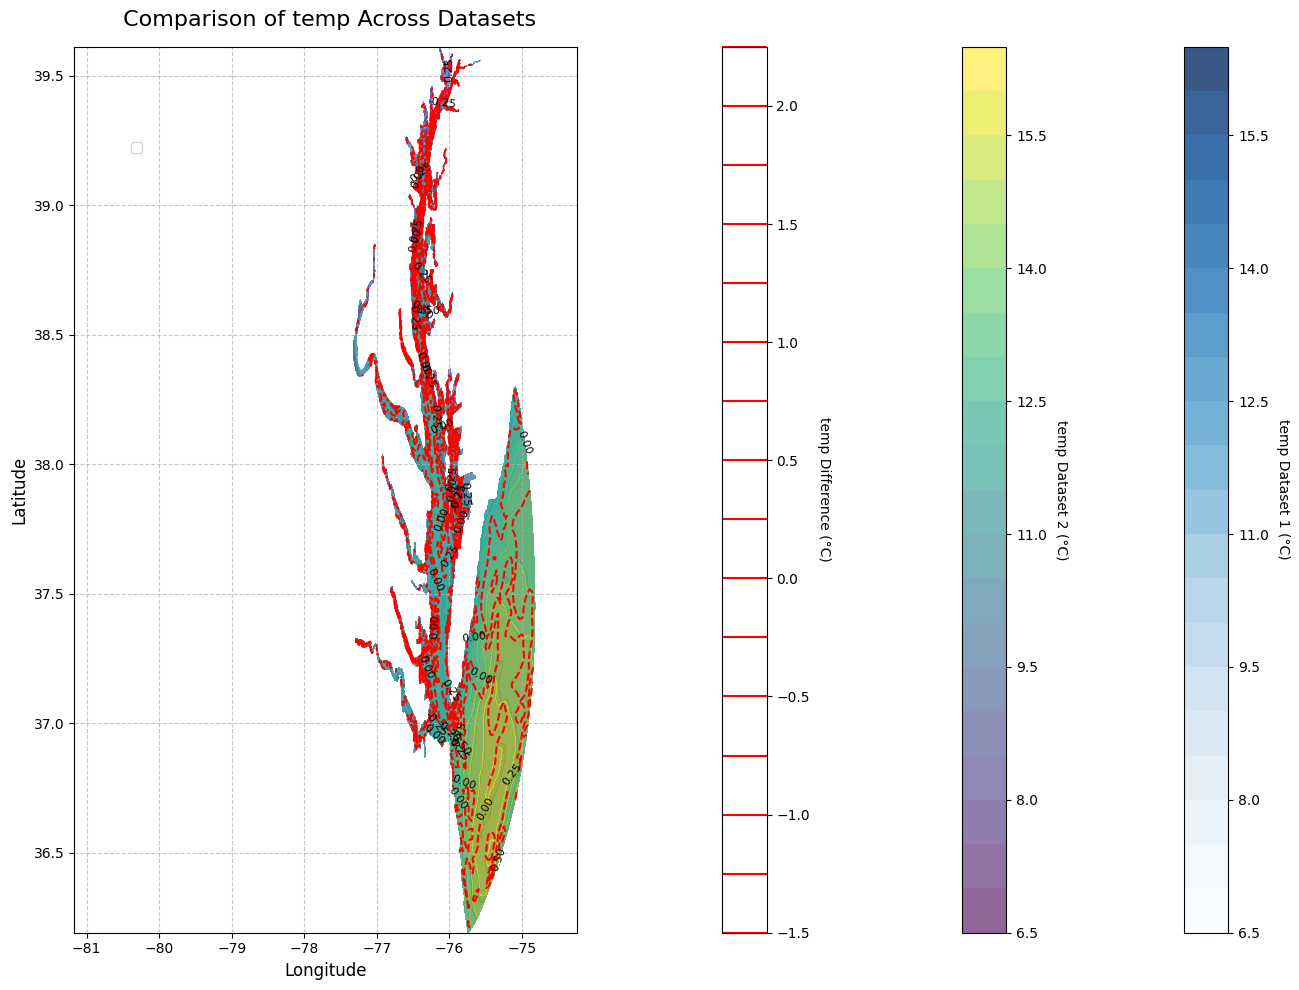

In [62]:
comparison_plots(ds1,ds2)